# 05 — Model Results: The Full Ladder

**Goal:** Run all four rungs of the model ladder, compare performance metrics, and produce the key diagnostic outputs.

**Sections:**
1. Setup & panel assembly
2. Run the ladder
3. Ladder chart (main result)
4. Per-pair performance table
5. Statement vs Digestion window comparison
6. Feature importance (permutation)
7. Residual diagnostics
8. Robustness checks
9. P&L strategy check
10. Save results

## 1. Setup & Panel Assembly

In [1]:
import sys
import pathlib

PROJECT_ROOT = pathlib.Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

DATA_CLEAN = PROJECT_ROOT / "data-clean"
OUTPUTS    = PROJECT_ROOT / "outputs"
FIGURES    = OUTPUTS / "figures"
FIGURES.mkdir(parents=True, exist_ok=True)

import logging
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

from src.config import load_config
from src.clean import read_parquet, write_parquet
from src.eval import assemble_panel, run_ladder, strategy_pnl, robustness_outlier_drop
from src.models import get_feature_cols, lomo_cv, build_ridge, build_gbr

logging.basicConfig(level=logging.INFO, format="%(levelname)s: %(message)s")
warnings.filterwarnings("ignore")

cfg = load_config(PROJECT_ROOT / "configs" / "config.yaml")

In [2]:
targets       = read_parquet(DATA_CLEAN / "targets.parquet")
feat_struct   = read_parquet(DATA_CLEAN / "features_structured.parquet")
feat_text_path = DATA_CLEAN / "features_text.parquet"
feat_text     = read_parquet(feat_text_path) if feat_text_path.exists() else None

panel = assemble_panel(targets, feat_struct, feat_text)
print(f"Panel: {panel.shape}")
print(f"Columns: {panel.columns.tolist()}")

# Save final panel
write_parquet(panel, DATA_CLEAN / "panel_final.parquet")

INFO: Read 328 rows ← /Users/jackgordon/Library/CloudStorage/OneDrive-Personal/04 Chicago Booth/01 Classes/35137 - ML in Finance/35137-ML-finance/final-project/data-clean/targets.parquet
INFO: Read 164 rows ← /Users/jackgordon/Library/CloudStorage/OneDrive-Personal/04 Chicago Booth/01 Classes/35137 - ML in Finance/35137-ML-finance/final-project/data-clean/features_structured.parquet
INFO: Read 82 rows ← /Users/jackgordon/Library/CloudStorage/OneDrive-Personal/04 Chicago Booth/01 Classes/35137 - ML in Finance/35137-ML-finance/final-project/data-clean/features_text.parquet
INFO: Panel assembled: 328 rows, 51 columns
INFO: Wrote 328 rows → /Users/jackgordon/Library/CloudStorage/OneDrive-Personal/04 Chicago Booth/01 Classes/35137 - ML in Finance/35137-ML-finance/final-project/data-clean/panel_final.parquet


Panel: (328, 51)
Columns: ['meeting_id', 'pair', 'window', 'announcement_et', 'log_ret', 'abs_ret', 'direction', 'n_bars', 'has_data', 'price_entry', 'price_exit', 'rate_change_bps', 'fed_minus_foreign_pre', 'spread_change', 'is_hike', 'is_cut', 'is_hold', 'dissent_count', 'ust2y_pre_chg', 'ust10y_pre_chg', 'slope_pre_change', 'spx_pre_ret_bps', 'vix_pre_level', 'vix_pre_change', 'text_source', 'hawkish_count', 'dovish_count', 'net_hawkish', 'net_hawkish_norm', 'balance_sheet_kw', 'uncertainty_kw', 'hawkish_dovish', 'inflation_focus', 'labor_focus', 'recession_risk', 'uncertainty_score', 'forward_guidance_strength', 'balance_sheet_mention', 'emb_pc_1', 'emb_pc_2', 'emb_pc_3', 'emb_pc_4', 'emb_pc_5', 'emb_pc_6', 'emb_pc_7', 'emb_pc_8', 'emb_pc_9', 'emb_pc_10', 'emb_pc_11', 'emb_pc_12', 'emb_pc_13']


## 2. Run the Ladder

In [3]:
# This runs LOO-CV for all rungs × windows × pairs. May take 1–3 minutes.
print("Running full model ladder (LOO-CV) ...")
results = run_ladder(
    panel=panel,
    cfg=cfg,
    target_col="log_ret",
    pairs=cfg.pairs,
    windows=["statement", "digestion"],
)

print(f"Results: {len(results)} rows")
results.head(12)

INFO: === Window: statement ===
INFO:   Rung 1 – Predict Zero | statement | pooled RMSE=0.00097 dir_acc=0.043
INFO:   Rung 1 – Hist Mean | statement | pooled RMSE=0.00096 dir_acc=0.482


Running full model ladder (LOO-CV) ...


INFO:   Rung 2 – OLS Theory | statement | pooled RMSE=0.00103 dir_acc=0.569
INFO:   Rung 3a – Ridge | statement | pooled RMSE=0.00114 dir_acc=0.513
INFO:   Rung 3a – LASSO | statement | pooled RMSE=0.00099 dir_acc=0.506
INFO:   Rung 3a – ElasticNet | statement | pooled RMSE=0.00099 dir_acc=0.506
INFO:   Rung 3a – Huber | statement | pooled RMSE=0.00116 dir_acc=0.532
INFO:   Rung 3b – GBR | statement | pooled RMSE=0.00113 dir_acc=0.487
INFO:   Rung 4 – +Keywords | statement | pooled RMSE=0.00127 dir_acc=0.487
INFO:   Rung 4 – +LLM Rubric | statement | pooled RMSE=0.00136 dir_acc=0.455
INFO:   Rung 4 – +Embeddings | statement | pooled RMSE=0.00172 dir_acc=0.404
INFO: === Window: digestion ===
INFO:   Rung 1 – Predict Zero | digestion | pooled RMSE=0.00455 dir_acc=0.000
INFO:   Rung 1 – Hist Mean | digestion | pooled RMSE=0.00453 dir_acc=0.561
INFO:   Rung 2 – OLS Theory | digestion | pooled RMSE=0.00504 dir_acc=0.463
INFO:   Rung 3a – Ridge | digestion | pooled RMSE=0.00575 dir_acc=0.481

Results: 110 rows


,rung,model_name,window,pair,mae,rmse,dir_acc,oos_r2,n
0,Rung 1 – Predict Zero,predict_zero,statement,USDEUR,0.000744,0.000941,0.048780,0.000000,41.0
1,Rung 1 – Predict Zero,predict_zero,statement,USDJPY,0.000930,0.001232,0.000000,0.000000,41.0
2,Rung 1 – Predict Zero,predict_zero,statement,USDGBP,0.000716,0.000906,0.073171,0.000000,41.0
3,Rung 1 – Predict Zero,predict_zero,statement,USDCAD,0.000561,0.000711,0.048780,0.000000,41.0
4,Rung 1 – Predict Zero,predict_zero,statement,ALL (pooled),0.000738,0.000966,0.042683,0.000000,164.0
5,Rung 1 – Hist Mean,hist_mean,statement,USDEUR,0.000752,0.000935,0.463415,0.012797,41.0
6,Rung 1 – Hist Mean,hist_mean,statement,USDJPY,0.000914,0.001222,0.585366,0.017120,41.0
7,Rung 1 – Hist Mean,hist_mean,statement,USDGBP,0.000719,0.000906,0.414634,0.000411,41.0
8,Rung 1 – Hist Mean,hist_mean,statement,USDCAD,0.000562,0.000711,0.463415,0.000699,41.0
9,Rung 1 – Hist Mean,hist_mean,statement,ALL (pooled),0.000741,0.000963,0.481707,0.006228,164.0


## 3. Ladder Chart (Main Result)

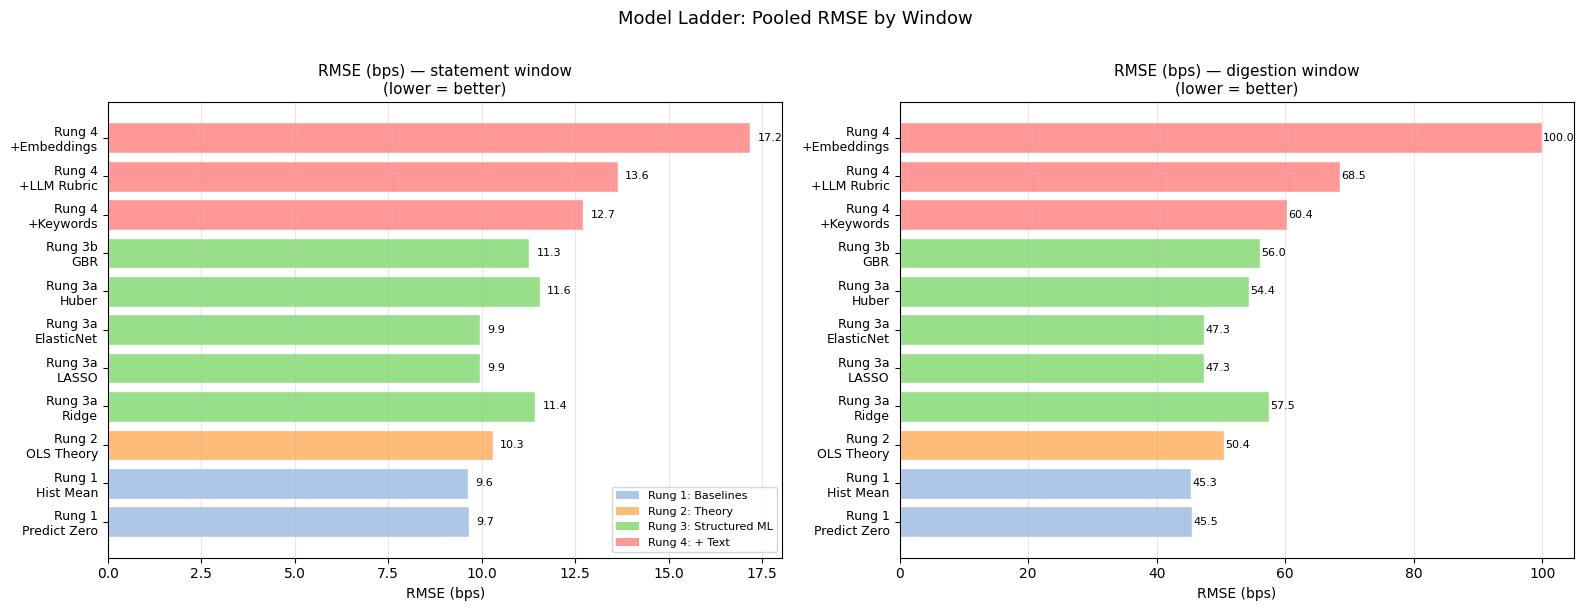

Saved → /Users/jackgordon/Library/CloudStorage/OneDrive-Personal/04 Chicago Booth/01 Classes/35137 - ML in Finance/35137-ML-finance/final-project/outputs/figures/ladder_rmse.png


In [4]:
# Pooled results for the ladder chart
pooled = results[results["pair"] == "ALL (pooled)"].copy()

rung_order = [
    "Rung 1 – Predict Zero",
    "Rung 1 – Hist Mean",
    "Rung 2 – OLS Theory",
    "Rung 3a – Ridge",
    "Rung 3a – LASSO",
    "Rung 3a – ElasticNet",
    "Rung 3a – Huber",
    "Rung 3b – GBR",
    "Rung 4 – +Keywords",
    "Rung 4 – +LLM Rubric",
    "Rung 4 – +Embeddings",
]
# Keep only rungs that have results
rung_order = [r for r in rung_order if r in pooled["rung"].values]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for ax, window in zip(axes, ["statement", "digestion"]):
    sub = pooled[pooled["window"] == window].set_index("rung").reindex(rung_order)
    
    colors = ["#aec7e8" if "Rung 1" in r else
              "#ffbb78" if "Rung 2" in r else
              "#98df8a" if "Rung 3" in r else
              "#ff9896" for r in rung_order]
    
    bars = ax.barh(range(len(rung_order)), sub["rmse"] * 10_000, color=colors, edgecolor="white")
    ax.set_yticks(range(len(rung_order)))
    ax.set_yticklabels([r.replace(" – ", "\n") for r in rung_order], fontsize=9)
    ax.set_title(f"RMSE (bps) — {window} window\n(lower = better)", fontsize=11)
    ax.set_xlabel("RMSE (bps)")
    ax.grid(True, alpha=0.3, axis="x")
    
    # Annotate bars
    for bar, val in zip(bars, sub["rmse"].values * 10_000):
        if not np.isnan(val):
            ax.text(bar.get_width() + 0.2, bar.get_y() + bar.get_height()/2,
                    f"{val:.1f}", va="center", ha="left", fontsize=8)

# Legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor="#aec7e8", label="Rung 1: Baselines"),
    Patch(facecolor="#ffbb78", label="Rung 2: Theory"),
    Patch(facecolor="#98df8a", label="Rung 3: Structured ML"),
    Patch(facecolor="#ff9896", label="Rung 4: + Text"),
]
axes[0].legend(handles=legend_elements, loc="lower right", fontsize=8)

plt.suptitle("Model Ladder: Pooled RMSE by Window", fontsize=13, y=1.01)
plt.tight_layout()
fig.savefig(FIGURES / "ladder_rmse.png", dpi=150, bbox_inches="tight")
plt.show()
print(f"Saved → {FIGURES / 'ladder_rmse.png'}")

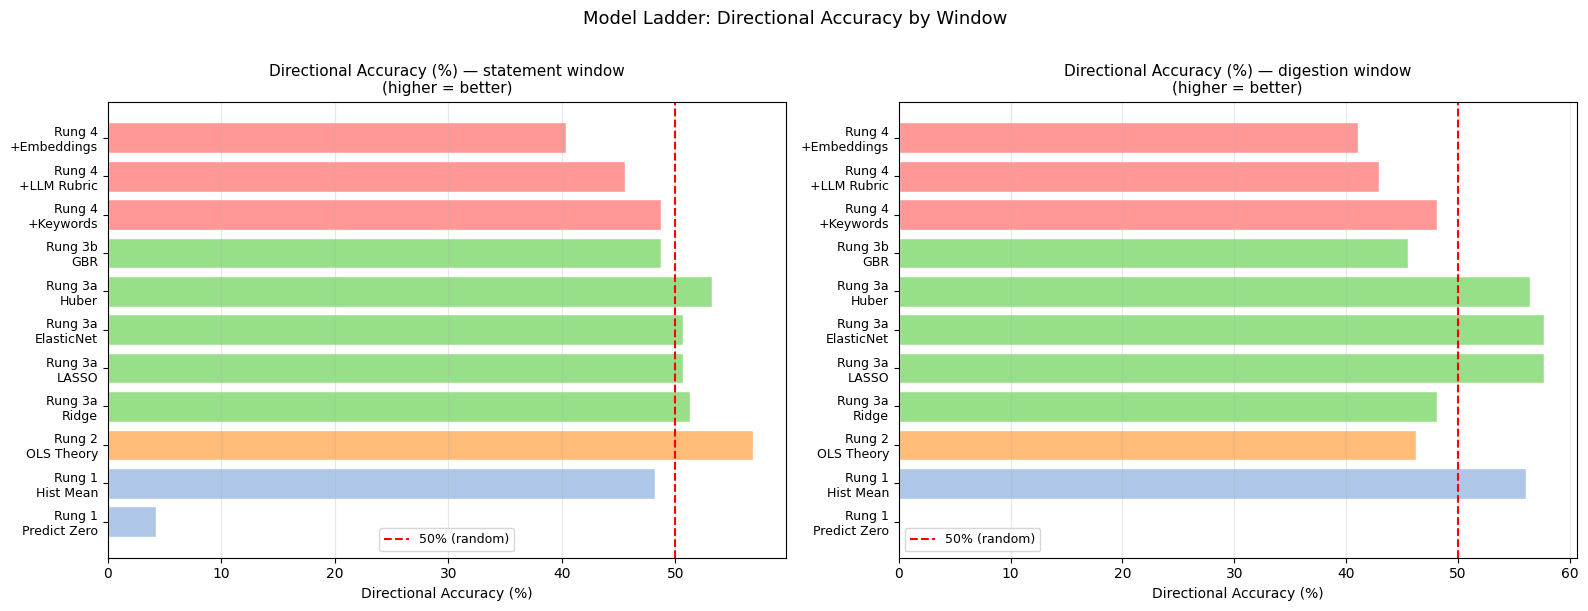

In [5]:
# Directional accuracy ladder
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for ax, window in zip(axes, ["statement", "digestion"]):
    sub = pooled[pooled["window"] == window].set_index("rung").reindex(rung_order)
    colors = ["#aec7e8" if "Rung 1" in r else
              "#ffbb78" if "Rung 2" in r else
              "#98df8a" if "Rung 3" in r else
              "#ff9896" for r in rung_order]

    ax.barh(range(len(rung_order)), sub["dir_acc"] * 100, color=colors, edgecolor="white")
    ax.axvline(50, color="red", lw=1.5, ls="--", label="50% (random)")
    ax.set_yticks(range(len(rung_order)))
    ax.set_yticklabels([r.replace(" – ", "\n") for r in rung_order], fontsize=9)
    ax.set_title(f"Directional Accuracy (%) — {window} window\n(higher = better)", fontsize=11)
    ax.set_xlabel("Directional Accuracy (%)")
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3, axis="x")

plt.suptitle("Model Ladder: Directional Accuracy by Window", fontsize=13, y=1.01)
plt.tight_layout()
fig.savefig(FIGURES / "ladder_dir_acc.png", dpi=150, bbox_inches="tight")
plt.show()

## 4. Per-Pair Performance Table

In [6]:
# Best model per rung (for display)
best_per_rung = {
    "Rung 1": "Rung 1 – Predict Zero",
    "Rung 2": "Rung 2 – OLS Theory",
    "Rung 3": "Rung 3a – Ridge",
    "Rung 4": "Rung 4 – +Embeddings",
}

pair_results = results[results["pair"].isin(cfg.pairs)].copy()

for window in ["statement", "digestion"]:
    print(f"\n=== Window: {window} — RMSE (bps) by pair × rung ===")
    sub = pair_results[pair_results["window"] == window].copy()
    sub["rmse_bps"] = (sub["rmse"] * 10_000).round(2)
    pivot = sub[sub["rung"].isin(best_per_rung.values())].pivot(
        index="pair", columns="rung", values="rmse_bps"
    )
    pivot.columns = [c.split(" – ")[0] for c in pivot.columns]
    print(pivot.to_string())


=== Window: statement — RMSE (bps) by pair × rung ===
        Rung 1  Rung 2  Rung 3a  Rung 4
pair                                   
USDCAD    7.11    7.76     8.89     NaN
USDEUR    9.41   10.33    11.10     NaN
USDGBP    9.06   10.39    11.06     NaN
USDJPY   12.32   14.00    15.73     NaN

=== Window: digestion — RMSE (bps) by pair × rung ===
        Rung 1  Rung 2  Rung 3a  Rung 4
pair                                   
USDCAD   38.50   41.04    47.91   68.16
USDEUR   46.79   53.02    60.43   93.45
USDGBP   49.74   53.52    60.13   66.43
USDJPY   46.17   50.91    56.90   86.63


## 5. Statement vs Digestion Window Comparison

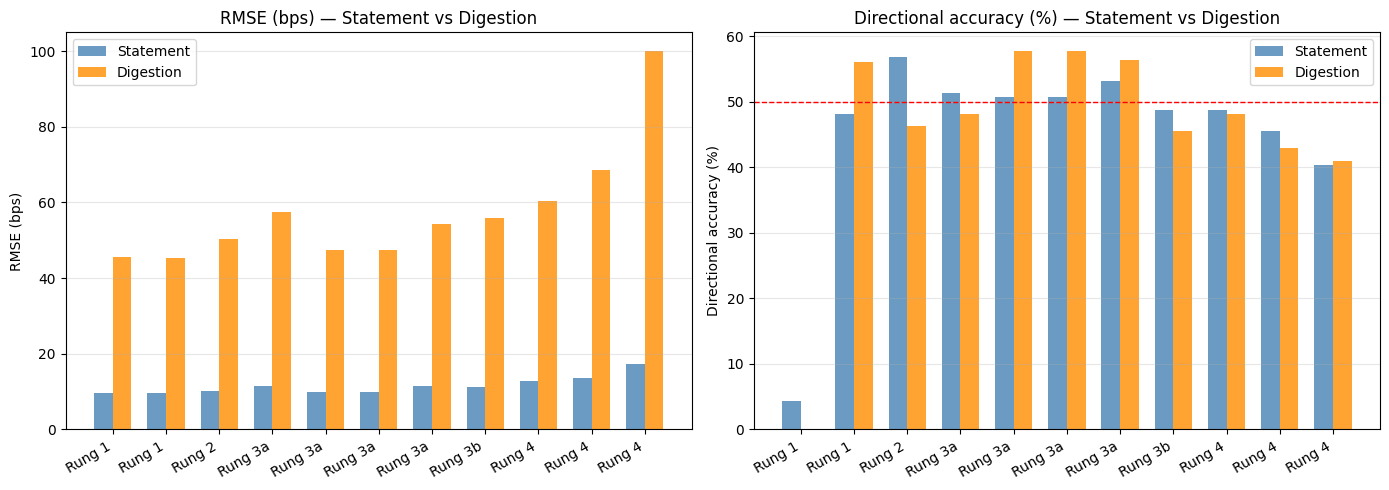

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, metric in zip(axes, ["rmse", "dir_acc"]):
    pivot = pooled.pivot(index="rung", columns="window", values=metric).reindex(rung_order)
    if metric == "rmse":
        pivot = pivot * 10_000
        ylabel = "RMSE (bps)"
    else:
        pivot = pivot * 100
        ylabel = "Directional accuracy (%)"

    x = np.arange(len(pivot))
    w = 0.35
    ax.bar(x - w/2, pivot.get("statement", pd.Series()), w, label="Statement", color="steelblue", alpha=0.8)
    ax.bar(x + w/2, pivot.get("digestion", pd.Series()), w, label="Digestion", color="darkorange", alpha=0.8)
    ax.set_xticks(x)
    ax.set_xticklabels([r.split(" – ")[0] for r in rung_order], rotation=30, ha="right")
    ax.set_title(f"{ylabel} — Statement vs Digestion")
    ax.set_ylabel(ylabel)
    ax.legend()
    ax.grid(True, alpha=0.3, axis="y")
    if metric == "dir_acc":
        ax.axhline(50, color="red", lw=1, ls="--")

plt.tight_layout()
fig.savefig(FIGURES / "window_comparison.png", dpi=150, bbox_inches="tight")
plt.show()

## 6. Feature Importance (Permutation)

In [8]:
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler

# Use the structured features + best rung-3 model (Ridge) for one window
feat_cols = get_feature_cols(panel, ["rung3_structured"])
window_to_eval = "statement"

sub = panel[panel["window"] == window_to_eval].copy()
sub = sub.dropna(subset=feat_cols + ["log_ret"])

from sklearn.linear_model import Ridge
scaler = StandardScaler()
X_all = scaler.fit_transform(sub[feat_cols].values)
y_all = sub["log_ret"].values

mdl = Ridge(alpha=1.0)
mdl.fit(X_all, y_all)

# Permutation importance (safer than coefficients for comparisons across feature scales)
perm_result = permutation_importance(mdl, X_all, y_all, n_repeats=20, random_state=42, scoring="neg_mean_squared_error")

imp_df = pd.DataFrame(
    {"feature": feat_cols, "importance": perm_result.importances_mean, "std": perm_result.importances_std}
).sort_values("importance", ascending=False)

print(f"Permutation importance ({window_to_eval} window, Ridge):")
print(imp_df.to_string(index=False))

Permutation importance (statement window, Ridge):
              feature   importance          std
              is_hike 1.902535e-07 4.600406e-08
      rate_change_bps 1.706187e-07 3.612730e-08
       vix_pre_change 1.339433e-07 3.649829e-08
        dissent_count 1.131212e-07 3.796441e-08
      spx_pre_ret_bps 8.803744e-08 3.596427e-08
               is_cut 8.435113e-08 3.126812e-08
              is_hold 3.076335e-08 2.127276e-08
fed_minus_foreign_pre 2.213311e-08 1.574325e-08
        ust2y_pre_chg 1.272002e-08 1.389610e-08
       ust10y_pre_chg 1.130686e-08 1.219833e-08
        spread_change 9.299814e-09 1.020566e-08
        vix_pre_level 7.422501e-09 7.712432e-09
     slope_pre_change 3.516665e-10 7.264581e-10


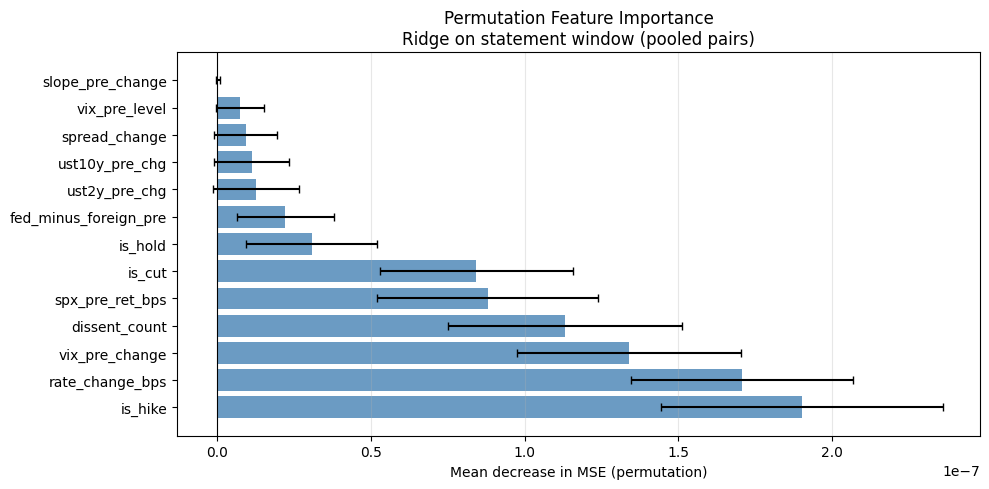

In [9]:
fig, ax = plt.subplots(figsize=(10, 5))
y_pos = range(len(imp_df))
ax.barh(y_pos, imp_df["importance"], xerr=imp_df["std"], color="steelblue", alpha=0.8, capsize=3)
ax.set_yticks(y_pos)
ax.set_yticklabels(imp_df["feature"])
ax.axvline(0, color="k", lw=0.8)
ax.set_title(f"Permutation Feature Importance\nRidge on {window_to_eval} window (pooled pairs)")
ax.set_xlabel("Mean decrease in MSE (permutation)")
ax.grid(True, alpha=0.3, axis="x")
plt.tight_layout()
fig.savefig(FIGURES / "feature_importance.png", dpi=150, bbox_inches="tight")
plt.show()

## 7. Residual Diagnostics

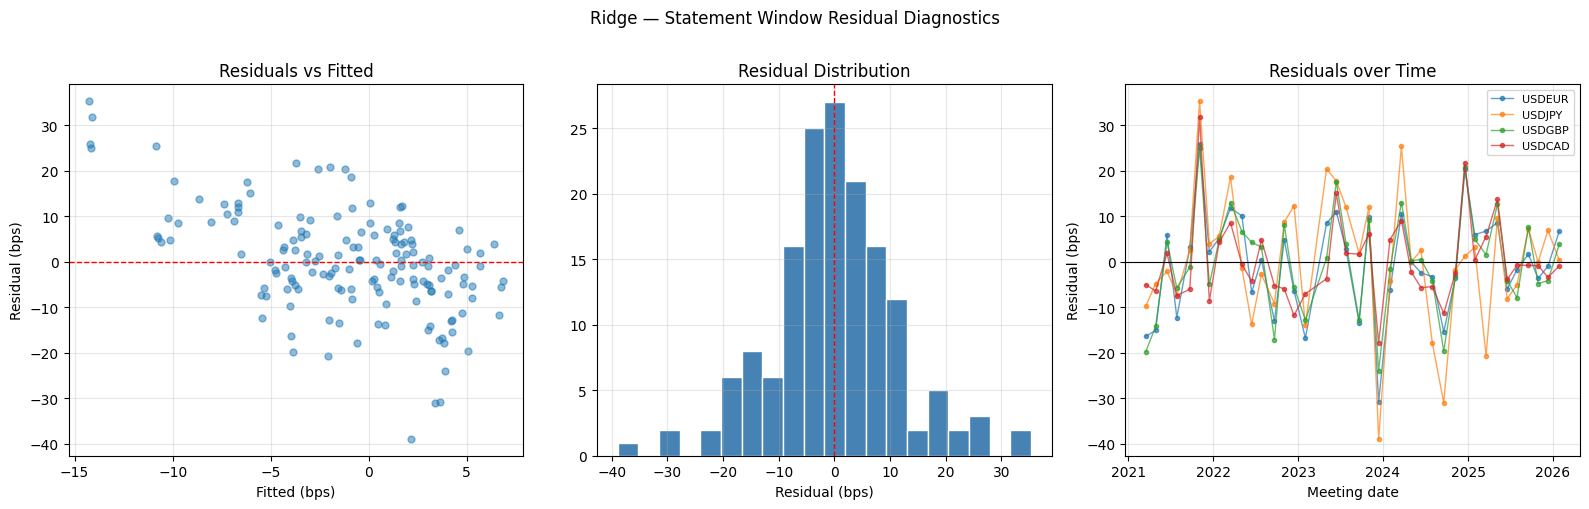

In [10]:
# Ridge LOO-CV residuals for statement window
sub_stmt = panel[panel["window"] == "statement"].copy()
feat_cols_struct = get_feature_cols(panel, ["rung3_structured"])

result = lomo_cv(sub_stmt, build_ridge, feat_cols_struct, "log_ret")
resid_df = pd.DataFrame({
    "actual_bps": result["actuals"] * 10_000,
    "pred_bps": result["preds"] * 10_000,
    "residual_bps": (result["actuals"] - result["preds"]) * 10_000,
    "meeting_id": result["meeting_ids"],
    "pair": result["pairs"],
})
resid_df = resid_df.merge(panel[["meeting_id", "announcement_et"]].drop_duplicates(), on="meeting_id", how="left")

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Residuals vs fitted
axes[0].scatter(resid_df["pred_bps"], resid_df["residual_bps"], alpha=0.5, s=25)
axes[0].axhline(0, color="red", lw=1, ls="--")
axes[0].set_title("Residuals vs Fitted")
axes[0].set_xlabel("Fitted (bps)")
axes[0].set_ylabel("Residual (bps)")
axes[0].grid(True, alpha=0.3)

# Residual distribution
axes[1].hist(resid_df["residual_bps"].dropna(), bins=20, edgecolor="white", color="steelblue")
axes[1].axvline(0, color="red", lw=1, ls="--")
axes[1].set_title("Residual Distribution")
axes[1].set_xlabel("Residual (bps)")
axes[1].grid(True, alpha=0.3)

# Residuals over time (by pair)
for pair in cfg.pairs:
    sub_p = resid_df[resid_df["pair"] == pair].sort_values("announcement_et")
    axes[2].plot(sub_p["announcement_et"], sub_p["residual_bps"], "o-", ms=3, lw=1, label=pair, alpha=0.7)
axes[2].axhline(0, color="k", lw=0.8)
axes[2].set_title("Residuals over Time")
axes[2].set_xlabel("Meeting date")
axes[2].set_ylabel("Residual (bps)")
axes[2].legend(fontsize=8)
axes[2].grid(True, alpha=0.3)

plt.suptitle("Ridge — Statement Window Residual Diagnostics", y=1.01)
plt.tight_layout()
fig.savefig(FIGURES / "residual_diagnostics.png", dpi=150, bbox_inches="tight")
plt.show()

## 8. Robustness Checks

In [11]:
# Robustness 1: drop 3 most extreme meetings
panel_robust = robustness_outlier_drop(panel, n_drop=3)
results_robust = run_ladder(
    panel=panel_robust, cfg=cfg, target_col="log_ret",
    pairs=cfg.pairs, windows=["statement", "digestion"]
)

print("Robustness (outlier drop): pooled RMSE comparison")
comp = pooled[pooled["pair"] == "ALL (pooled)"][["rung", "window", "rmse"]].rename(columns={"rmse": "rmse_full"})
comp_r = results_robust[results_robust["pair"] == "ALL (pooled)"][["rung", "window", "rmse"]].rename(columns={"rmse": "rmse_robust"})
comp = comp.merge(comp_r, on=["rung", "window"], how="left")
comp[["rmse_full", "rmse_robust"]] = comp[["rmse_full", "rmse_robust"]] * 10_000
comp["delta_bps"] = (comp["rmse_robust"] - comp["rmse_full"]).round(2)
print(comp[["rung", "window", "rmse_full", "rmse_robust", "delta_bps"]].to_string(index=False))

INFO: Outlier robustness: dropping meetings ['20221102', '20240918', '20220504']
INFO: === Window: statement ===
INFO:   Rung 1 – Predict Zero | statement | pooled RMSE=0.00096 dir_acc=0.039
INFO:   Rung 1 – Hist Mean | statement | pooled RMSE=0.00096 dir_acc=0.480
INFO:   Rung 2 – OLS Theory | statement | pooled RMSE=0.00099 dir_acc=0.628
INFO:   Rung 3a – Ridge | statement | pooled RMSE=0.00112 dir_acc=0.542
INFO:   Rung 3a – LASSO | statement | pooled RMSE=0.00099 dir_acc=0.507
INFO:   Rung 3a – ElasticNet | statement | pooled RMSE=0.00099 dir_acc=0.507
INFO:   Rung 3a – Huber | statement | pooled RMSE=0.00114 dir_acc=0.576
INFO:   Rung 3b – GBR | statement | pooled RMSE=0.00115 dir_acc=0.500
INFO:   Rung 4 – +Keywords | statement | pooled RMSE=0.00127 dir_acc=0.451
INFO:   Rung 4 – +LLM Rubric | statement | pooled RMSE=0.00141 dir_acc=0.465
INFO:   Rung 4 – +Embeddings | statement | pooled RMSE=0.00179 dir_acc=0.375
INFO: === Window: digestion ===
INFO:   Rung 1 – Predict Zero | di

Robustness (outlier drop): pooled RMSE comparison
                 rung    window  rmse_full  rmse_robust  delta_bps
Rung 1 – Predict Zero statement   9.658531     9.572424      -0.09
   Rung 1 – Hist Mean statement   9.628409     9.560653      -0.07
  Rung 2 – OLS Theory statement  10.292826     9.883824      -0.41
      Rung 3a – Ridge statement  11.434961    11.225338      -0.21
      Rung 3a – LASSO statement   9.946988     9.914210      -0.03
 Rung 3a – ElasticNet statement   9.946988     9.914210      -0.03
      Rung 3a – Huber statement  11.551456    11.419228      -0.13
        Rung 3b – GBR statement  11.278993    11.520441       0.24
   Rung 4 – +Keywords statement  12.709602    12.660676      -0.05
 Rung 4 – +LLM Rubric statement  13.639932    14.101515       0.46
 Rung 4 – +Embeddings statement  17.188520    17.853125       0.66
Rung 1 – Predict Zero digestion  45.488025    36.923089      -8.56
   Rung 1 – Hist Mean digestion  45.326242    36.203850      -9.12
  Rung 2 – O

In [12]:
# Robustness 2: per-pair vs pooled directional accuracy comparison
print("Per-pair vs pooled directional accuracy (statement window):")
per_pair = results[(results["window"] == "statement") & results["pair"].isin(cfg.pairs)].copy()
per_pair_agg = per_pair.groupby("rung")["dir_acc"].mean().rename("per_pair_avg")
pooled_dir = pooled[pooled["window"] == "statement"].set_index("rung")["dir_acc"].rename("pooled")
print(pd.concat([per_pair_agg, pooled_dir], axis=1).round(3).to_string())

Per-pair vs pooled directional accuracy (statement window):
                       per_pair_avg  pooled
rung                                       
Rung 1 – Hist Mean            0.482   0.482
Rung 1 – Predict Zero         0.043   0.043
Rung 2 – OLS Theory           0.550   0.569
Rung 3a – ElasticNet          0.494   0.506
Rung 3a – Huber               0.506   0.532
Rung 3a – LASSO               0.494   0.506
Rung 3a – Ridge               0.494   0.513
Rung 3b – GBR                 0.481   0.487
Rung 4 – +Embeddings            NaN   0.404
Rung 4 – +Keywords            0.468   0.487
Rung 4 – +LLM Rubric          0.526   0.455


## 9. P&L Strategy Check

In [13]:
# Strategy P&L for the best model (Ridge, statement window)
sub_stmt_pnl = panel[panel["window"] == "statement"].copy()
feat_cols_struct = get_feature_cols(panel, ["rung3_structured"])

pnl_df = strategy_pnl(
    panel=sub_stmt_pnl,
    model_builder=build_ridge,
    feature_cols=feat_cols_struct,
    target_col="log_ret",
    transaction_cost_bps=cfg.strategy.transaction_cost_bps,
)

print(f"Gross Sharpe: {pnl_df.attrs['gross_sharpe']:.2f}")
print(f"Net Sharpe:   {pnl_df.attrs['net_sharpe']:.2f}")
print(f"Win rate:     {(pnl_df['gross_ret'] > 0).mean()*100:.1f}%")

INFO: Strategy P&L: gross Sharpe=-0.35  net Sharpe=-2.89  (n=156, tc=2 bps)


Gross Sharpe: -0.35
Net Sharpe:   -2.89
Win rate:     51.3%


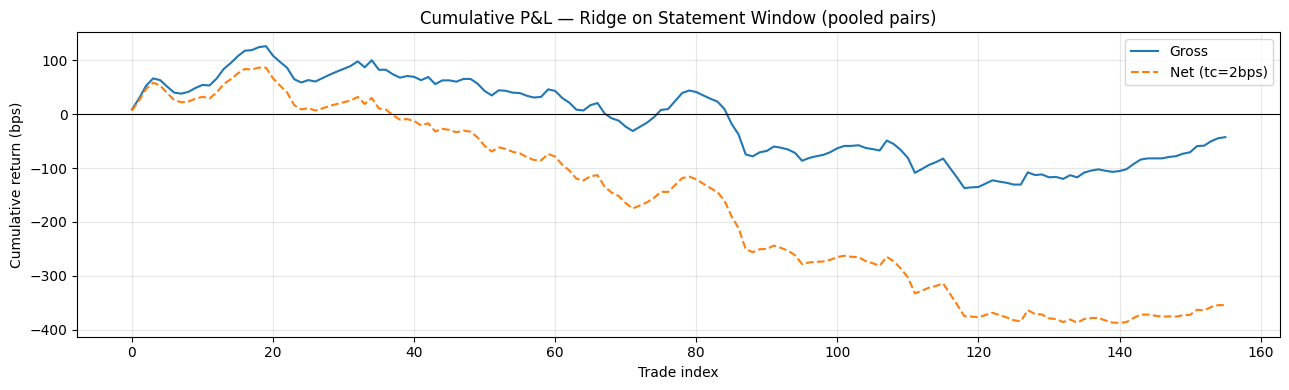

In [14]:
fig, ax = plt.subplots(figsize=(13, 4))
ax.plot(range(len(pnl_df)), pnl_df["cum_gross"] * 10_000, label="Gross", lw=1.5)
ax.plot(range(len(pnl_df)), pnl_df["cum_net"] * 10_000, label=f"Net (tc={cfg.strategy.transaction_cost_bps}bps)", lw=1.5, ls="--")
ax.axhline(0, color="k", lw=0.8)
ax.set_title("Cumulative P&L — Ridge on Statement Window (pooled pairs)")
ax.set_xlabel("Trade index")
ax.set_ylabel("Cumulative return (bps)")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
fig.savefig(FIGURES / "cumulative_pnl.png", dpi=150, bbox_inches="tight")
plt.show()

## 10. Save Results

In [15]:
OUTPUTS.mkdir(exist_ok=True)
results.to_csv(OUTPUTS / "model_results.csv", index=False)
print(f"Saved model_results.csv ({len(results)} rows)")

# Summary table for report
summary = results[
    results["pair"] == "ALL (pooled)"
][["rung", "window", "mae", "rmse", "dir_acc", "oos_r2", "n"]].copy()
summary[["mae", "rmse"]] = summary[["mae", "rmse"]] * 10_000
summary["dir_acc"] = summary["dir_acc"] * 100
summary.columns = ["Rung", "Window", "MAE (bps)", "RMSE (bps)", "Dir Acc (%)", "OOS R²", "N"]
print(summary.round(2).to_string(index=False))

Saved model_results.csv (110 rows)
                 Rung    Window  MAE (bps)  RMSE (bps)  Dir Acc (%)  OOS R²     N
Rung 1 – Predict Zero statement       7.38        9.66         4.27    0.00 164.0
   Rung 1 – Hist Mean statement       7.41        9.63        48.17    0.01 164.0
  Rung 2 – OLS Theory statement       7.69       10.29        56.88   -0.12 160.0
      Rung 3a – Ridge statement       8.52       11.43        51.28   -0.36 156.0
      Rung 3a – LASSO statement       7.64        9.95        50.64   -0.03 156.0
 Rung 3a – ElasticNet statement       7.64        9.95        50.64   -0.03 156.0
      Rung 3a – Huber statement       8.53       11.55        53.21   -0.39 156.0
        Rung 3b – GBR statement       8.62       11.28        48.72   -0.32 156.0
   Rung 4 – +Keywords statement       9.51       12.71        48.72   -0.68 156.0
 Rung 4 – +LLM Rubric statement      10.31       13.64        45.51   -0.93 156.0
 Rung 4 – +Embeddings statement      13.74       17.19        4

## Summary

**Outputs written:**
- `outputs/model_results.csv` — full metric table
- `outputs/figures/ladder_rmse.png` — main ladder chart
- `outputs/figures/ladder_dir_acc.png` — directional accuracy
- `outputs/figures/window_comparison.png` — statement vs digestion
- `outputs/figures/feature_importance.png` — permutation importance
- `outputs/figures/residual_diagnostics.png` — residual plots
- `outputs/figures/cumulative_pnl.png` — P&L chart
- `data-clean/panel_final.parquet` — final modeling panel